In [6]:
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
from scipy.ndimage import zoom


In [2]:
# os.mkdir('./cats')
# os.mkdir('./dogs')


1/1 [==============================] - 0s 54ms/step


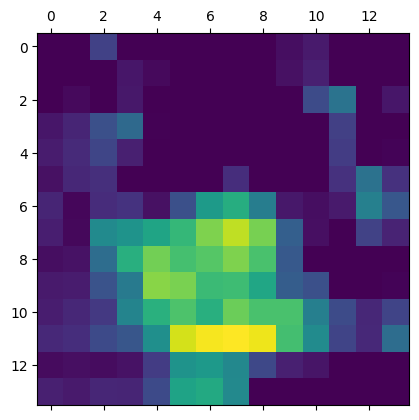

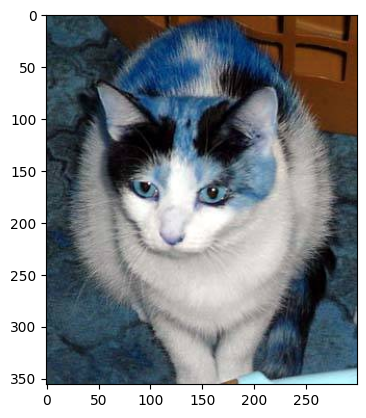

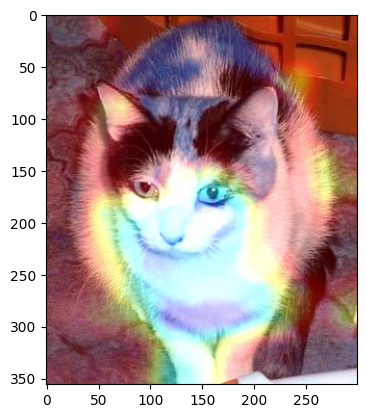

In [12]:
model = VGG16(weights='imagenet')

last_conv_layer_name = "block5_conv3"
model_cam = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(expanded_img_array)

img_path = './cats/cat.111.jpg'
preprocessed_img = load_and_preprocess_image(img_path)

feature_maps, predictions = model_cam.predict(preprocessed_img)

predicted_class = np.argmax(predictions)


with tf.GradientTape() as tape:
    last_conv_layer_output, preds = model_cam(preprocessed_img)
    top_pred_index = preds[:, predicted_class]
    tape.watch(last_conv_layer_output)
    top_class_channel = preds[:, predicted_class]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

plt.matshow(heatmap)
plt.show()


img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./superimposed_img.jpg', superimposed_img)

img = cv2.imread('./superimposed_img.jpg')
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 468ms/step
Predictions: [('n02106550', 'Rottweiler', 0.66648406), ('n02108551', 'Tibetan_mastiff', 0.06501567), ('n02096051', 'Airedale', 0.024722274)]


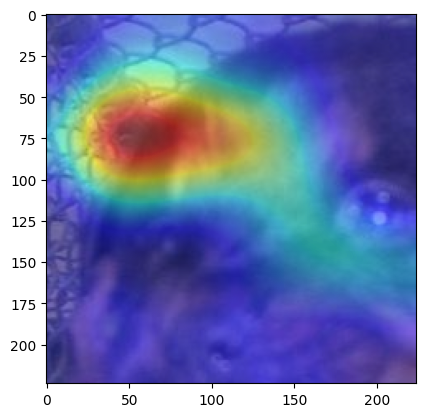

In [9]:
model = EfficientNetB0(weights='imagenet')

model = Model(inputs=model.inputs, outputs=[model.get_layer('top_activation').output, model.output])

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(expanded_img_array)

img_path = './dogs/dog.999.jpg'
preprocessed_img = load_and_preprocess_image(img_path)

feature_maps, predictions = model.predict(preprocessed_img)

print('Predictions:', decode_predictions(predictions, top=3)[0])

predicted_class = np.argmax(predictions)
gap_weights = np.mean(feature_maps[0], axis=(0, 1))

cam = np.dot(feature_maps[0], gap_weights)
cam = zoom(cam, (224 / cam.shape[0], 224 / cam.shape[1]))
cam = np.maximum(cam, 0)
cam = cam / cam.max()

plt.imshow(image.load_img(img_path))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()